# Example: mesh a delineated watershed

Here we mesh the [Coweeta Hydrologic Laboratory](https://www.srs.fs.usda.gov/coweeta/) as an example of how to pull data in from default locations and generate a fully functional ATS mesh.

This might be the worst example to use to learn how to use Watershed Workflows.  But it is useful to demonstrate the breadth of problems this project was intended to solve.

This includes a range of datasets:

* NHD Plus for river network
* NRCS soils data for soil types
* NLCD for land cover/transpiration/rooting depths
* NED for elevation

In [1]:
# %matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
# %matplotlib osx

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [4]:
import sys
# sys.path.append("./")
sys.path.append("/Users/shua784/Dropbox/github/seacas/install/lib")

sys.path.append("../../workflow-test")
sys.path.append("../workflow_tpls")
sys.path.append("../workflow")

In [5]:
import os,sys
import numpy as np
import pandas as pd
import scipy
import scipy.spatial
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
import shapely
import logging
import pandas
pandas.options.display.max_columns = None


import workflow
import workflow.source_list
import workflow.ui
import workflow.colors
import workflow.condition
import workflow.mesh
import workflow.split_hucs

workflow.ui.setup_logging(1,None)
figsize = (6,6)
figsize_3d = (8,6)

In [99]:
watershed_name = "CoalCreek"
meshRes = "100m-frac1pct"
fname_surface_mesh = f"./meshes/{watershed_name}_surface_mesh.vtk"
fname_final_mesh = f"./meshes/{watershed_name}_mesh-{meshRes}.exo"

fig_mesh = "./figures/{}_mesh.png".format(watershed_name)
fig_mesh3D = "./figures/{}_mesh3D.png".format(watershed_name)
fig_soil_type = "./figures/{}_soil_type.png".format(watershed_name)
fig_geol_map = "./figures/{}_geol_map.png".format(watershed_name)
fig_land_cover = "./figures/{}_land_cover.png".format(watershed_name)
fig_hru = "./figures/{}_HRU.png".format(watershed_name)
fig_DTB = "./figures/{}_DTB.png".format(watershed_name)

fname_mesh_pickle = f'./results/{watershed_name}_mesh.p'
fname_soil_id = f'/Users/shua784/OneDrive - PNNL/github/east-taylor/data/material/{watershed_name}_soil_id-{meshRes}.txt'
fname_geol_id = f'/Users/shua784/OneDrive - PNNL/github/east-taylor/data/material/{watershed_name}_geol_id-{meshRes}.txt'

fname_soil_prop = f"/Users/shua784/OneDrive - PNNL/github/east-taylor/data/material/{watershed_name}_soil_prop-{meshRes}.csv"
fname_geol_prop = f"/Users/shua784/OneDrive - PNNL/github/east-taylor/data/material/{watershed_name}_geol_prop-{meshRes}.csv"

fname_nlcd = f"/Users/shua784/OneDrive - PNNL/github/east-taylor/data/material/{watershed_name}_nlcd-{meshRes}.csv"

In [7]:
# specify the input shapefile and a hint as to what HUC it is in.
watershed_shapefile = '/Users/shua784/OneDrive - PNNL/github/watershed-workflow/data/hydrologic_units/EastTaylor/CoalCreek.shp'

fname_dem = "/Users/shua784/OneDrive - PNNL/Projects/Exasheds/Upper_Colorado_River_Basin/GIS/EastTaylor_DEM/GreaterEastTayor_dem_10m.tif"
fname_soil = "/Users/shua784/OneDrive - PNNL/Projects/Exasheds/Upper_Colorado_River_Basin/GIS/gNATSGO/gNATSGO_CO_raster/MapunitRaster_10m1.tif"
fname_DTB = "/Users/shua784/OneDrive - PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/global/depth-to-bedrock/Global_absoluteDTB_M_250m_ll.tif"
# fname_geology = "/Users/shua784/OneDrive - PNNL/Projects/Exasheds/Upper_Colorado_River_Basin/GIS/EastTaylor_GLHYMPS/EastTaylor_GLHYMPS_v2.shp"
fname_geology = "/Users/shua784/OneDrive - PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/global/GLHYMPS_v2/GLHYMPS.shp"

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

In [8]:
# specify the input shapefile and a hint as to what HUC it is in.
# watershed_shapefile = watershed_shapefile



logging.info("")
logging.info("Meshing shape: {}".format(watershed_shapefile))
logging.info("="*30)

# get the shape and crs of the shape
crs, watershed = workflow.get_split_form_shapes(watershed_shapefile)

2021-02-19 10:51:52,233 - root - INFO: 
2021-02-19 10:51:52,234 - root - INFO: Meshing shape: /Users/shua784/OneDrive - PNNL/github/watershed-workflow/data/hydrologic_units/EastTaylor/CoalCreek.shp
2021-02-19 10:51:52,234 - root - INFO: ==============================
2021-02-19 10:51:52,235 - root - INFO: 
2021-02-19 10:51:52,235 - root - INFO: Preprocessing Shapes
2021-02-19 10:51:52,236 - root - INFO: ------------------------------
2021-02-19 10:51:52,236 - root - INFO: loading file: "/Users/shua784/OneDrive - PNNL/github/watershed-workflow/data/hydrologic_units/EastTaylor/CoalCreek.shp"


A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [9]:
# set up a dictionary of source objects
sources = workflow.source_list.get_default_sources()
sources['hydrography'] = workflow.source_list.hydrography_sources['NHD Plus']
sources['HUC'] = workflow.source_list.huc_sources['NHD Plus']
workflow.source_list.log_sources(sources)

2021-02-19 10:51:53,704 - root - INFO: Using sources:
2021-02-19 10:51:53,705 - root - INFO: --------------
2021-02-19 10:51:53,705 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2021-02-19 10:51:53,706 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2021-02-19 10:51:53,706 - root - INFO: DEM: National Elevation Dataset (NED)
2021-02-19 10:51:53,707 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2021-02-19 10:51:53,707 - root - INFO: geologic structure: GLHYMPS version 2.0
2021-02-19 10:51:53,707 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2021-02-19 10:51:53,708 - root - INFO: soil thickness: None
2021-02-19 10:51:53,708 - root - INFO: meteorology: DayMet 1km


## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

In [10]:
hint = '1402'  # hint: HUC 4 containing this shape.  
               # This is necessary to avoid downloading all HUCs to search for this shape
simplify = 30 # length scale to target average edge

In [11]:
# find what HUC our shape is in
huc = workflow.find_huc(sources['HUC'], watershed.exterior(), crs, hint, shrink_factor=0.1)
logging.info("Found watershed in HUC: {}".format(huc))

2021-02-08 22:38:42,935 - root - INFO: 
2021-02-08 22:38:42,935 - root - INFO: Preprocessing HUC
2021-02-08 22:38:42,936 - root - INFO: ------------------------------
2021-02-08 22:38:42,936 - root - INFO: Loading level 4 HUCs in 1402.
2021-02-08 22:38:55,852 - root - INFO:   REST query with polyCode... SUCCESS
2021-02-08 22:38:55,853 - root - INFO:   REST query: https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/WBD/HU2/GDB/WBD_14_HU2_GDB.zip
2021-02-08 22:38:55,854 - root - INFO: Downloading: "https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/WBD/HU2/GDB/WBD_14_HU2_GDB.zip"
2021-02-08 22:38:55,855 - root - INFO:          to: "/Users/shua784/github/workflow-test/examples/data/hydrography/WBD_14_GDB/raw/WBD_14_HU2_GDB.zip"
2021-02-08 22:38:55,856 - root - INFO:        cert: "True"
2021-02-08 22:39:01,755 - root - INFO: Unzipping: "/Users/shua784/github/workflow-test/examples/data/hydrography/WBD_14_GDB/raw/WBD_14_HU2_GDB.zip"
2021-02-08 22:39:01,755 - root - INFO:   

In [10]:
huc = "140200010204" # provide the HUC8/HUC12 for NHD or HUC4 for NHDPlus that includes that watershed
simplify = 30 # length scale to target average edge

rivers = True
if rivers:
    # download/collect the river network within that shape's bounds
    _, reaches = workflow.get_reaches(sources['hydrography'], huc, 
                                      watershed.exterior().bounds, crs)
    # simplify and prune rivers not IN the shape, constructing a tree-like data structure
    # for the river network
    rivers = workflow.simplify_and_prune(watershed, reaches, filter=True, simplify=simplify, cut_intersections=True,
                                         ignore_small_rivers=2, prune_by_area_fraction=0.01
                                        )

else:
    rivers = list()
    workflow.split_hucs.simplify(watershed, simplify)



2021-02-19 10:52:13,729 - root - INFO: 
2021-02-19 10:52:13,730 - root - INFO: Preprocessing Hydrography
2021-02-19 10:52:13,730 - root - INFO: ------------------------------
2021-02-19 10:52:13,731 - root - INFO: Loading streams in HUC 140200010204
2021-02-19 10:52:13,731 - root - INFO:          and/or bounds (317251.2640131897, 4299711.408984916, 328473.7039815487, 4307062.45088187)
2021-02-19 10:52:13,732 - root - INFO: Using Hydrography file "/Users/shua784/github/workflow-test/examples/data/hydrography/NHDPlus_H_1402_GDB/NHDPlus_H_1402.gdb"
2021-02-19 10:52:14,686 - root - INFO:   found 201 reaches
2021-02-19 10:53:08,292 - root - INFO: 
2021-02-19 10:53:08,293 - root - INFO: Simplifying and pruning
2021-02-19 10:53:08,293 - root - INFO: ------------------------------
2021-02-19 10:53:08,294 - root - INFO: Filtering rivers outside of the HUC space
2021-02-19 10:53:08,294 - root - INFO:   ...filtering
2021-02-19 10:53:08,326 - root - INFO:   filtered from 201 to 118 reaches.
2021-0

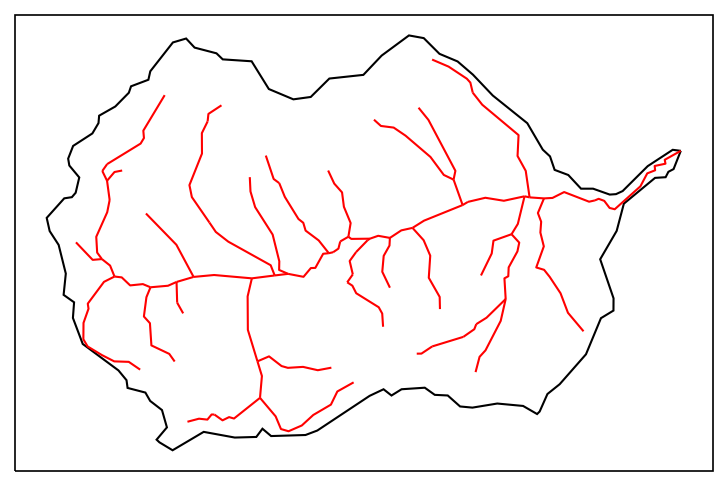

In [53]:
# plot what we have so far -- an image of the HUC and its stream network
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)

plt.show()

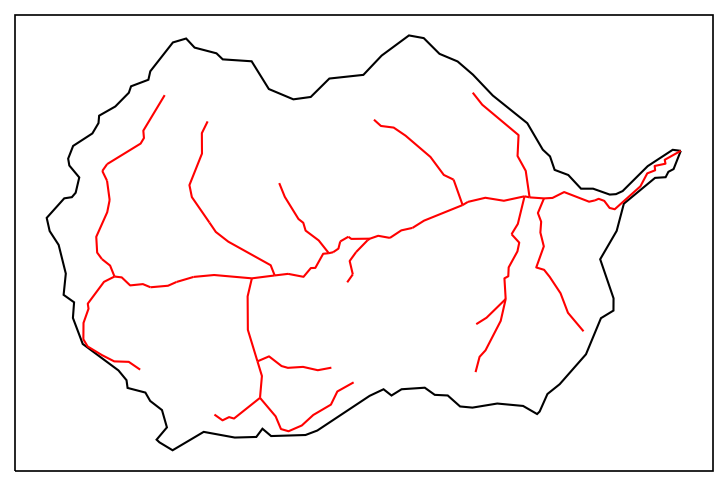

In [66]:
# prune by area= 0.02

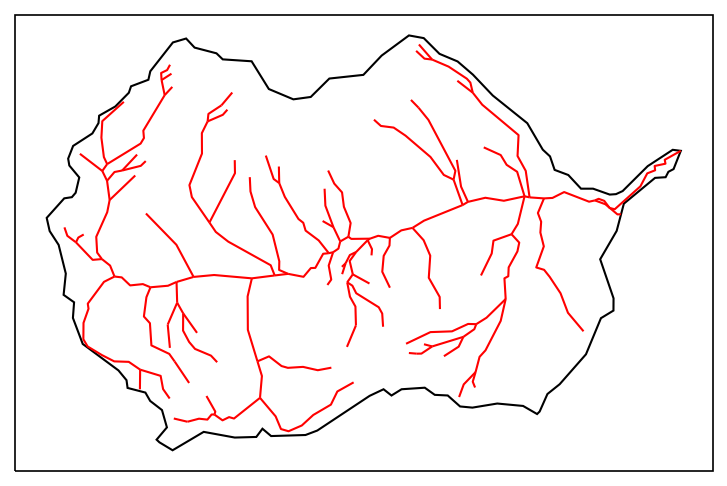

In [13]:
# NHD Plus or NHD Plus HR?

2021-03-03 10:42:21,614 - root - INFO: 
2021-03-03 10:42:21,614 - root - INFO: Meshing
2021-03-03 10:42:21,615 - root - INFO: ------------------------------
2021-03-03 10:42:21,616 - root - INFO: Triangulating...
2021-03-03 10:42:21,617 - root - INFO:    97 points and 97 facets
2021-03-03 10:42:21,618 - root - INFO:  checking graph consistency
2021-03-03 10:42:21,618 - root - INFO:  tolerance is set to 1
2021-03-03 10:42:21,619 - root - INFO:  building graph data structures
2021-03-03 10:42:21,620 - root - INFO:  triangle.build...
2021-03-03 10:42:24,123 - root - INFO:   ...built: 4633 mesh points and 9040 triangles
2021-03-03 10:42:24,124 - root - INFO: Plotting triangulation diagnostics
2021-03-03 10:42:24,859 - root - INFO:   min area = 1419.6597900390625
2021-03-03 10:42:24,860 - root - INFO:   max area = 49289.118408203125


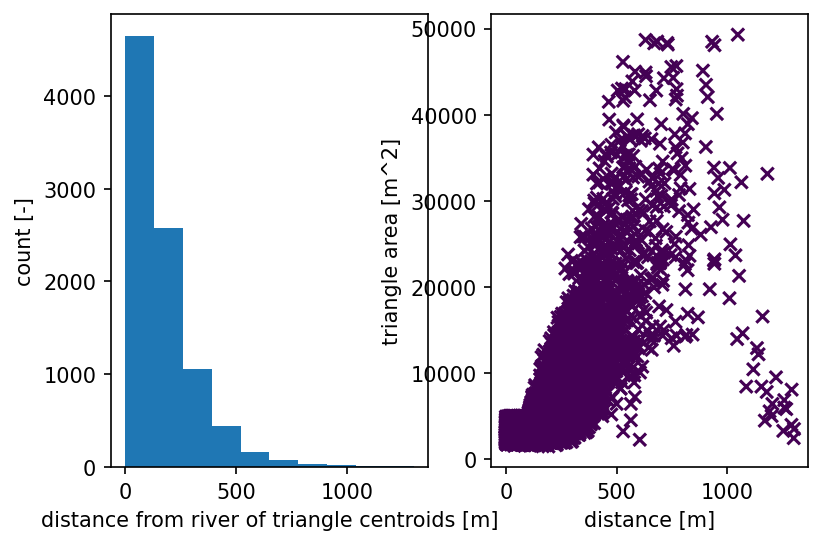

In [70]:
# form a triangulation on the shape + river network

# triangulation refinement:
# Refine triangles if their area (in m^2) is greater than A(d), where d is the 
# distance from the triangle centroid to the nearest stream.
# A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and
# linearly interpolates between the two endpoints.
d0 = 100; d1 = 500
# A0 = 50; A1 = 50000 # [10, 310] m
#A0 = 500; A1 = 2500
#A0 = 100; A1 = 500
# A0 = 10000; A1 = 50000 # [140, 310]m
A0 = 5000; A1 = 50000 # [100, 310]m
# A0 = 1000; A1 = 50000 # [45, 310]m
# A0 = 1250; A1 = 50000 # [50, 310]m

# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
mesh_points2, mesh_tris, areas = workflow.triangulate(watershed, rivers, 
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               diagnostics=True)
#mesh_points2, mesh_tris, d = workflow.triangulate(watershed, rivers,
#                                                 refine_max_area=100000,
#                                                 enforce_delaunay=True,
#                                                 diagnostics=True)

2021-03-03 10:20:26,382 - root - INFO: 
2021-03-03 10:20:26,383 - root - INFO: Preprocessing Raster
2021-03-03 10:20:26,384 - root - INFO: ------------------------------
2021-03-03 10:20:26,388 - root - INFO: collecting raster
2021-03-03 10:20:26,585 - root - INFO: Collecting DEMs to tile bounds: [-107.11979680283598, 38.815001709752224, -106.96391191732934, 38.9073673161621]
2021-03-03 10:20:26,593 - root - INFO:   Need:
2021-03-03 10:20:26,593 - root - INFO:     /Users/shua784/github/workflow-test/examples/data/dem/USGS_NED_1as_n39_w108.img
2021-03-03 10:20:26,593 - root - INFO:     /Users/shua784/github/workflow-test/examples/data/dem/USGS_NED_1as_n39_w107.img
2021-03-03 10:20:26,594 - root - INFO: source files already exist!
2021-03-03 10:20:26,670 - root - INFO: Got raster of shape: (333, 562)
2021-03-03 10:20:26,670 - root - INFO: Raster bounds: (-107.11979680283598, 38.9073673161621, -106.96368569172475, 38.81486731616203)


<Figure size 900x600 with 0 Axes>

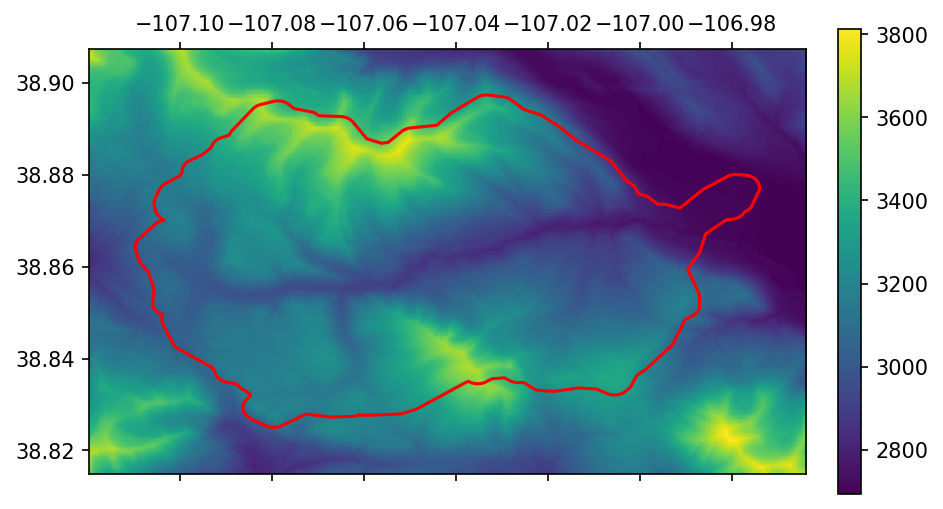

In [56]:
# get a raster for the elevation map, based on NED
dem_profile, dem = workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs, 
                                                buffer = 300, plot_dem = True, 
#                                                resampling_res=30, resampling_method = 'cubic'
                                               )

**smooth dem**

2021-03-03 10:20:33,795 - root - INFO: smoothing using Gaussian filter with sigma = 3...
2021-03-03 10:20:33,807 - root - INFO: 
2021-03-03 10:20:33,808 - root - INFO: Elevating Triangulation to DEM
2021-03-03 10:20:33,808 - root - INFO: ------------------------------
2021-03-03 10:20:33,983 - root - INFO: raw minmax: 2693.51953125, 3812.509521484375
2021-03-03 10:20:33,985 - root - INFO: smoothed minmax: 2693.530029296875, 3778.167724609375


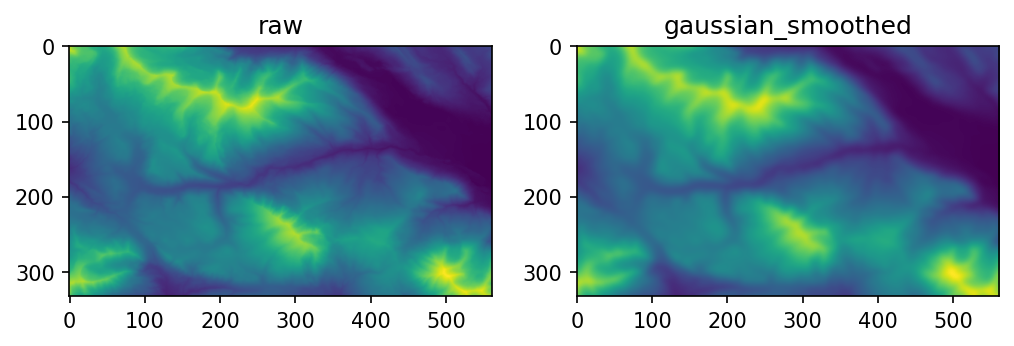

In [57]:
smooth = True
if smooth:
    sigma = 3
    logging.info(f"smoothing using Gaussian filter with sigma = {sigma}...")
    dem_s = gaussian_filter(dem, sigma = sigma, mode='nearest')
    mesh_points3 = workflow.elevate(mesh_points2, crs, dem_s, dem_profile)

    fig, axes = plt.subplots(1,2, figsize=(8,4))
    ax = axes[0]
    ax.imshow(dem)
    ax.set_title('raw')
    logging.info(f'raw minmax: {np.min(dem)}, {np.max(dem)}')
    ax = axes[1]
    ax.imshow(dem_s)
    ax.set_title('gaussian_smoothed')
    logging.info(f'smoothed minmax: {np.min(dem_s)}, {np.max(dem_s)}')
else:
    # elevate the triangle nodes to the dem
    mesh_points3 = workflow.elevate(mesh_points2, crs, dem, dem_profile)

Plotting the resulting mesh can be done in a variety of ways, including both 3D plots and mapview.  We show both here, but hereafter use mapview plots as they are a bit clearer (if not so flashy)...

[Text(4299000.0, 0, ''),
 Text(4300000.0, 0, ''),
 Text(4301000.0, 0, ''),
 Text(4302000.0, 0, ''),
 Text(4303000.0, 0, ''),
 Text(4304000.0, 0, ''),
 Text(4305000.0, 0, ''),
 Text(4306000.0, 0, ''),
 Text(4307000.0, 0, ''),
 Text(4308000.0, 0, '')]

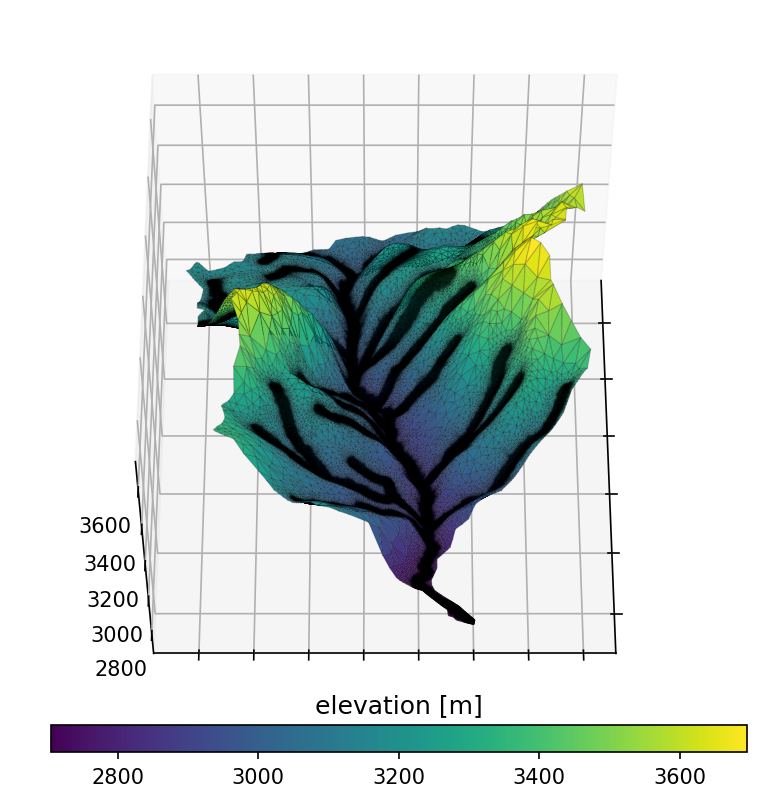

In [15]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize_3d)
ax = workflow.plot.get_ax('3d', fig, window=[0.0,0.2,1,0.8])
cax = fig.add_axes([0.23,0.18,0.58,0.03])

mp = ax.plot_trisurf(mesh_points3[:,0], mesh_points3[:,1], mesh_points3[:,2], 
                     triangles=mesh_tris, cmap='viridis', 
                     edgecolor=(0,0,0,.2), linewidth=0.5)
cb = fig.colorbar(mp, orientation="horizontal", cax=cax)

t = cax.set_title('elevation [m]')
ax.view_init(55,0)
ax.set_xticklabels(list())
ax.set_yticklabels(list())

#fig.savefig('watershed_dem_3d')

(316690.15495, 329034.55405000004)
(4299344.330884162, 4307420.049100754)


Text(0.5, 1.0, 'elevation [m]')

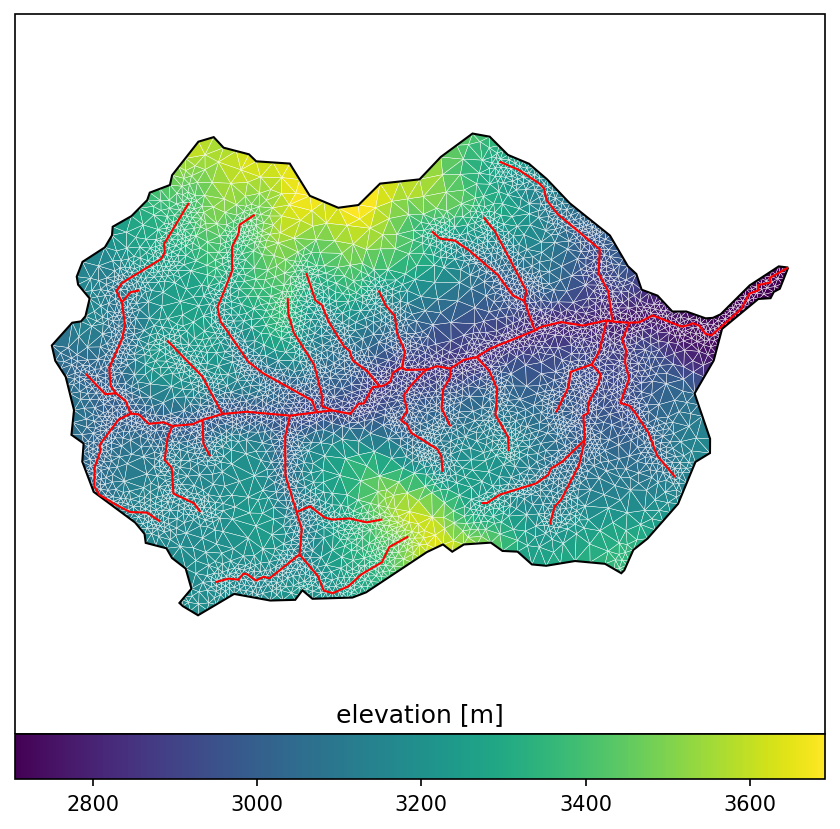

In [58]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
#ax2 = workflow.plot.get_ax(crs,fig, window=[0.65,0.05,0.3,0.5])
# ax2 = ax.inset_axes([0.65,0.05,0.3,0.5])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])

xlim = (275900., 276400.)
ylim = (3882300., 3883000.)

mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color='elevation', edgecolor='white', linewidth=0.2)
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)
ax.set_aspect('equal', 'datalim')

# mp2 = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
#                                  color='elevation', edgecolor='white', linewidth=0.2)
# workflow.plot.hucs(watershed, crs, ax=ax2, color='k', linewidth=1)
# workflow.plot.rivers(rivers, crs, ax=ax2, color='red', linewidth=1.5)
# ax2.set_xlim(xlim)
# ax2.set_ylim(ylim)
# ax2.set_xticks([])
# ax2.set_yticks([])

# ax.indicate_inset_zoom(ax2, edgecolor='k')


print(ax.get_xlim())
print(ax.get_ylim())
cbar.ax.set_title('elevation [m]')
# fig.savefig('watershed_dem2')

(316690.15495, 329034.55405000004)
(4299344.330884162, 4307420.049100754)


Text(0.5, 1.0, 'elevation [m]')

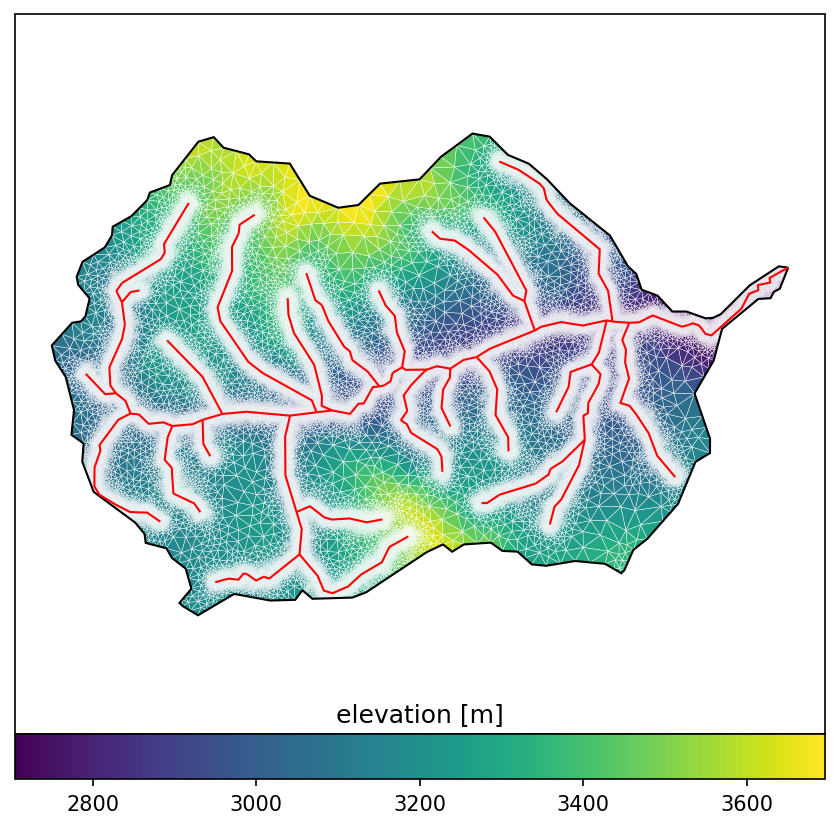

In [59]:
# construct the 2D mesh
m2 = workflow.mesh.Mesh2D(mesh_points3.copy(), list(mesh_tris))

2021-03-03 10:21:02,664 - root - INFO: max diff = 41.774390588601364 


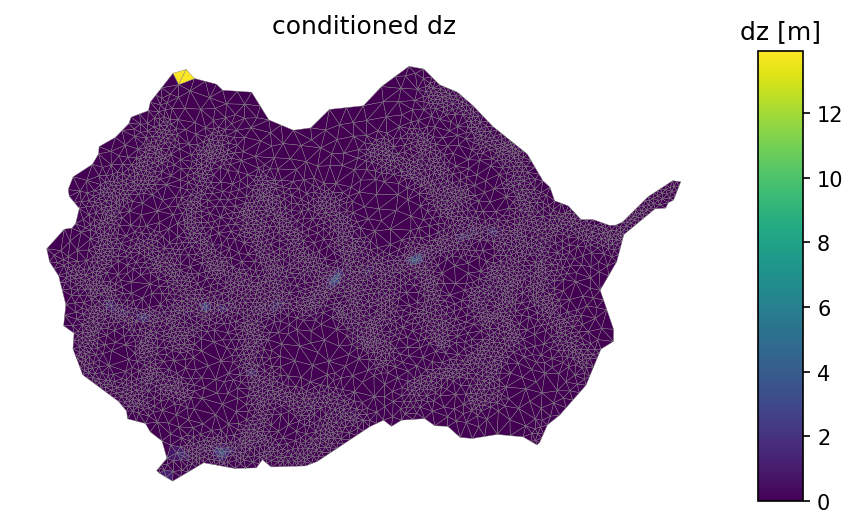

In [60]:
# hydrologically condition the mesh, removing pits
workflow.condition.condition(m2)

# plot the change between the two meshes
diff = np.copy(mesh_points3)
diff[:,2] = m2.points[:,2] - mesh_points3[:,2] 
logging.info(f"max diff = {np.abs(diff[:,2]).max()} ")
fig, ax = workflow.plot.get_ax(crs, figsize=figsize)
cbax = fig.add_axes([.95,0.25,0.05,0.5])

mp = workflow.plot.triangulation(diff, m2.conn, crs, color='elevation', edgecolors='gray', 
                            linewidth=0.2, ax=ax)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
cbar.ax.set_title('dz [m]')
ax.axis('off')
ax.set_title('conditioned dz')
plt.show()

## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed.

In [61]:
# download the NLCD raster
lc_profile, lc_raster = workflow.get_raster_on_shape(sources['land cover'], 
                                                     watershed.exterior(), crs)

# resample the raster to the triangles
lc = workflow.values_from_raster(m2.centroids(), crs, lc_raster, lc_profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))


2021-03-03 10:25:21,440 - root - INFO: 
2021-03-03 10:25:21,441 - root - INFO: Preprocessing Raster
2021-03-03 10:25:21,441 - root - INFO: ------------------------------
2021-03-03 10:25:21,442 - root - INFO: collecting raster
2021-03-03 10:25:21,460 - root - INFO: CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["meters",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
2021-03-03 10:25:21,617 - root - INFO: Got raster of shape: (245, 374)
2021-03-03 10:25:21,618 - root - INFO: Raster bounds: (-952

In [62]:
# plot the NLCD data

# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                workflow.colors.generate_nlcd_colormap(lc)

# this is just hacking the label names to make them display a bit neater for a cleaner plot.  Likely it 
# should get put into the NLCD manager instead of here! See #8
nlcd_labels_fw = []
for label in nlcd_labels:
    label_fw = label
    if len(label) > 15:
        if ' ' in label:
            lsplit = label.split()
            if len(lsplit) == 2:
                label_fw = '\n'.join(lsplit)
            elif len(lsplit) == 4:
                label_fw = '\n'.join([' '.join(lsplit[0:2]),
                                      ' '.join(lsplit[2:])])
            elif len(lsplit) == 3:
                if len(lsplit[0]) > len(lsplit[-1]):
                    label_fw = '\n'.join([lsplit[0],
                                          ' '.join(lsplit[1:])])
                else:
                    label_fw = '\n'.join([' '.join(lsplit[:-1]),
                                          lsplit[-1]])
    nlcd_labels_fw.append(label_fw)

In [100]:
if len(nlcd_indices) != len(nlcd_labels):
    nlcd_labels = [i for i in nlcd_labels if i]
    assert(len(nlcd_indices) == len(nlcd_labels))

area_list = [areas[lc==i].sum() for i in nlcd_indices]
area_coverage = np.array(area_list) / areas.sum() * 100

nlcd_df = pd.DataFrame([nlcd_indices, nlcd_labels, area_list]).T
nlcd_df.columns = ['id', 'name', 'area']
nlcd_df.set_index('id', inplace = True)

nlcd_df['coverage [%]'] = area_coverage

nlcd_df.to_csv(fname_nlcd)

Text(0.5, 1.0, 'land cover index')

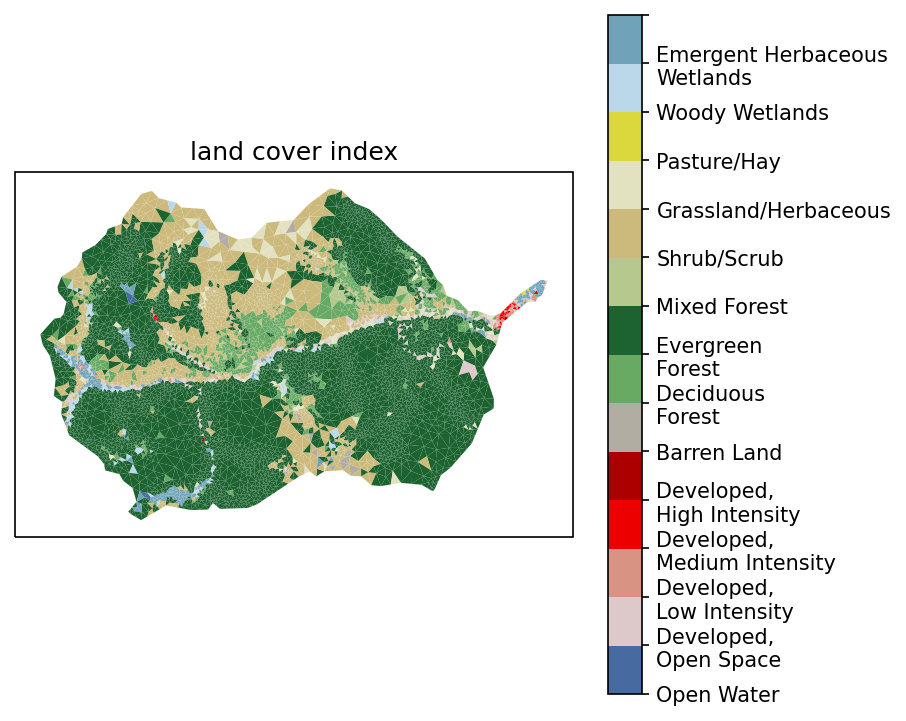

In [93]:
# plot the image
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

polys = workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=nlcd_cmap, norm=nlcd_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)
mp = pcm.ScalarMappable(norm=nlcd_norm, cmap=nlcd_cmap)
cb = fig.colorbar(mp)
cb.set_ticks(nlcd_ticks)
cb.set_ticklabels(nlcd_labels_fw)
ax.set_title("land cover index")
# fig.savefig('watershed_nlcd')

## Subsurface properties

Get soil structure from SSURGO.  By soil structure, here we calculate, for each formation identified in SSURGO, a soil depth, porosity, permeability, and percent sand/silt/clay (which are then handed off to Rosetta to get a van Genuchten model). 

Below this soil we also identify a geologic layer provided by GLHYMPS.  This provides information about the deeper subsurface.

### SSURGO Soil Properties

### option 1

In [19]:
# soil_profile, soil_raster = workflow.get_raster_on_shape(fname_soil, watershed.exterior(), crs)

# # resample the raster to the triangles
# soil_color = workflow.values_from_raster(m2.centroids(), crs, soil_raster, soil_profile)

### option 2

In [115]:
# download the NRCS soils data as shapes and project it onto the mesh
import matplotlib.cm

# -- download the shapes
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))
_, soil_survey, soil_survey_props = workflow.get_shapes(sources['soil structure'], target_bounds, crs, properties=True)

# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = np.array([shp.properties['id'] for shp in soil_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_raster, soil_color_profile, img_bounds = \
            workflow.color_raster_from_shapes(target_bounds, 10, soil_survey,
                                              soil_ids, crs)

# -- resample the raster to the triangles
soil_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         soil_color_raster, soil_color_profile)

2021-03-03 11:16:38,206 - root - INFO: target bounds: (317251.2640131897, 4299711.408984916, 328473.4449929282, 4307052.970983125)
2021-03-03 11:16:38,207 - root - INFO: 
2021-03-03 11:16:38,207 - root - INFO: Preprocessing Shapes
2021-03-03 11:16:38,208 - root - INFO: ------------------------------
2021-03-03 11:16:38,384 - root - INFO: Attempting to download source for target '/Users/shua784/github/workflow-test/examples/data/soil_structure/SSURGO/SSURGO_-107.1073_38.8271_-106.9759_38.8957.gml'
../../workflow-test/workflow/sources/manager_nrcs.py:272: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  shapes = [_flip(s) for s in fid]
2021-03-03 11:16:38,404 - root - INFO:   Found 103 shapes.
2021-03-03 11:16:38,405 - root - INFO:   and crs: EPSG:4326
2021-03-03 11:16:38,413 - root - INFO: found 33 unique MUKEYs.
2021-03-03 11:16:40,074 - root - INFO: Running Rosetta for van Genutchen parameters
2021-03-03 11:

In [116]:
area_list = [areas[soil_color==i].sum() for i in np.unique(soil_color)]
assert(np.sum(area_list) == areas.sum())
area_coverage = np.array(area_list) / areas.sum() * 100

In [117]:
soil_survey_props.set_index('mukey', inplace = True)
# sub_soil_props = soil_survey_props.loc[unique_soil_id,:]
soil_id_df = pd.DataFrame(np.array(np.unique(soil_color, return_counts=True)).T, columns = ['mukey', 'count'])
soil_id_df.set_index('mukey', inplace = True)
soil_id_df['area'] = area_list
soil_id_df['coverage [%]'] = area_coverage

soil_prop_df = soil_survey_props.merge(soil_id_df, how = 'inner', left_on='mukey', right_on = 'mukey', sort = True)
soil_prop_df.to_csv(fname_soil_prop)

In [28]:
# soil_survey_props.head()

# unique_soil_id = np.unique(soil_color)

# logging.info(f'unique soil MUKEYs:\n {np.array(np.unique(soil_color, return_counts=True)).T}')

# np.savetxt(fname_soil_id, np.array(np.unique(soil_color, return_counts=True)).T, 
#            delimiter=' ', fmt = '%.0d')

# soil_survey_props.set_index('mukey', inplace = True, drop = False)

# sub_soil_props = soil_survey_props.loc[unique_soil_id, :]

# sub_soil_props.head()

# sub_soil_props.to_csv(fname_soil_prop)

Text(0.5, 1.0, 'soil type index')

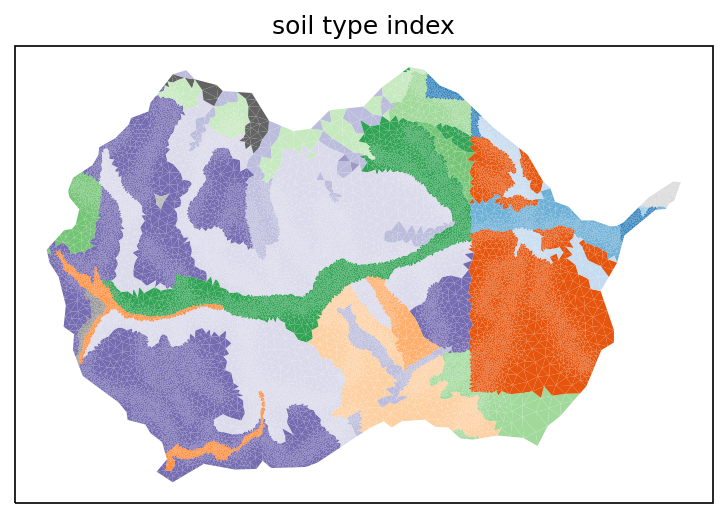

In [127]:
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(soil_color, cmap = 'tab20c')

# plot the soil mukey
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color, 
                        cmap=cmap, norm = norm
                       )
ax.set_title('soil type index')

# fig.savefig('watershed_soils')

In [ ]:
# # Note this is not just the soil ID, but also soil properties.  
# # print(soil_survey_props.keys())

# # To demonstrate what we mean by this, plot the porosity of the soil column.
# fig = plt.figure(figsize=(12,6))
# porosity_nrcs = np.empty(soil_color.shape, 'd')
# porosity_rosetta = np.empty(soil_color.shape, 'd')

# for mukey in soil_survey_props['mukey']:
#     porosity_nrcs[soil_color == mukey] = soil_survey_props.loc[soil_survey_props['mukey']==mukey,'porosity [-]']
#     porosity_rosetta[soil_color == mukey] = soil_survey_props.loc[soil_survey_props['mukey']==mukey,'Rosetta porosity [-]']

# pmin = min(np.nanmin(porosity_nrcs), np.nanmin(porosity_rosetta))
# pmax = max(np.nanmax(porosity_nrcs), np.nanmax(porosity_rosetta))
# print('min, max = ', pmin, pmax)

# ax1 = workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=1)
# mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax1, 
#                                  color=porosity_nrcs, edgecolor='gray', cmap='jet', vmin=pmin, vmax=pmax)
# cbar = fig.colorbar(mp)
# ax1.set_title('porosity (NRCS) [-]')

# ax2 = workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=2)
# mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
#                                  color=porosity_rosetta, edgecolor='gray', cmap='jet', vmin=pmin, vmax=pmax)
# cbar = fig.colorbar(mp)
# ax2.set_title('porosity (Rosetta) [-]')

# # fig.savefig('watershed_porosity')

Median soil thickness [m] =  1.52


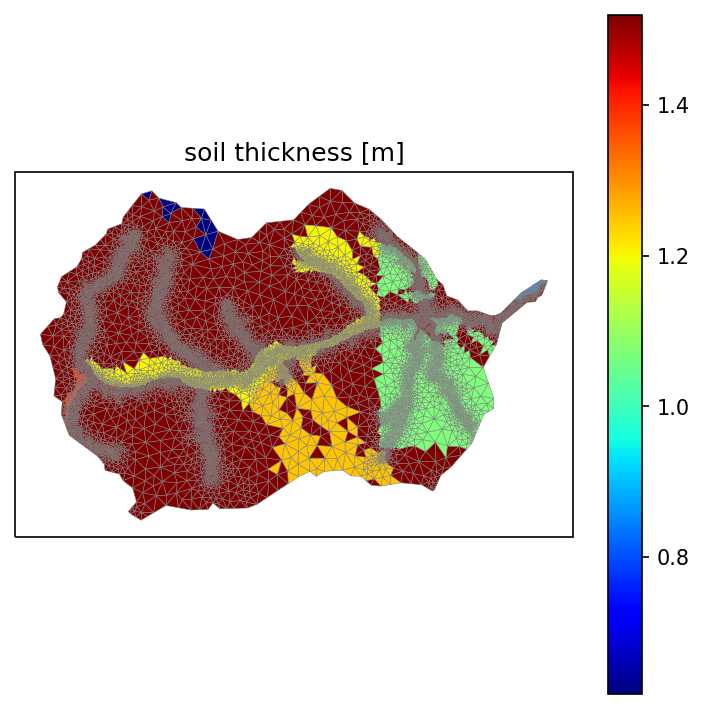

In [61]:
# what do soil thicknesses look like?
fig = plt.figure(figsize=figsize)
soil_thickness = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props['mukey']:
    soil_thickness[soil_color == mukey] = soil_survey_props.loc[soil_survey_props['mukey'] == mukey,'thickness [cm]']

ax = workflow.plot.get_ax(crs, fig)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=soil_thickness/100, edgecolor='gray', cmap='jet')
cbar = fig.colorbar(mp)
ax.set_title('soil thickness [m]')

print('Median soil thickness [m] = ', np.median(soil_thickness)/100)

# fig.savefig('watershed_soil_thickness')


In [ ]:
# # averaging permeability is a tricky beast.  we average in log space, check that unit conversions make sense
# fig = plt.figure(figsize=(12,6))
# soil_perm_nrcs = np.empty(soil_color.shape, 'd')
# soil_perm_rosetta = np.empty(soil_color.shape, 'd')

# for mukey in soil_survey_props['mukey']:
#     soil_perm_nrcs[soil_color == mukey] = soil_survey_props.loc[soil_survey_props['mukey'] == mukey, 'permeability [m^2]']
#     soil_perm_rosetta[soil_color == mukey] = soil_survey_props.loc[soil_survey_props['mukey'] == mukey, 'Rosetta permeability [m^2]']

# pmin = min(np.nanmin(np.log10(soil_perm_nrcs)), np.nanmin(np.log10(soil_perm_rosetta)))
# pmax = max(np.nanmax(np.log10(soil_perm_nrcs)), np.nanmax(np.log10(soil_perm_rosetta)))

  
# print(f'min = {pmin}, max = {pmax}')

# ax1 = workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=1)
# mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax1, 
#                                  color=np.log10(soil_perm_nrcs), edgecolor='gray', cmap='jet',
#                                 vmin=pmin, vmax=pmax)
# cbar = fig.colorbar(mp)
# ax1.set_title('log permeability (NRCS) [m^2]')

# ax2 = workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=2)
# mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
#                                  color=np.log10(soil_perm_rosetta), edgecolor='gray', cmap='jet',
#                                 vmin=pmin, vmax=pmax)
# cbar = fig.colorbar(mp)
# ax2.set_title('log permeability (Rosetta) [m^2]')


# # fig.savefig('watershed_permeability')



### GLYHMPS geologic layer

In [123]:
# extract the GLYHMPS geologic structure data as shapes and project it onto the mesh
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))

_, geo_survey, geo_survey_props = workflow.get_shapes(sources['geologic structure'], target_bounds, crs, properties=True)

# -- log the bounds targetted and found
logging.info('shape union bounds: {}'.format(
    shapely.ops.cascaded_union(geo_survey).bounds))

# -- determine the ID for each soil unit; this uniquely identifies formation
#    properties
geo_ids = np.array([shp.properties['id'] for shp in geo_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
geo_color_raster, geo_color_profile, img_bounds = \
            workflow.color_raster_from_shapes(target_bounds, 10, geo_survey,
                                              geo_ids, crs)

# -- resample the raster to the triangles
geo_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         geo_color_raster, geo_color_profile)


2021-03-03 11:21:47,503 - root - INFO: target bounds: (317251.2640131897, 4299711.408984916, 328473.4449929282, 4307052.970983125)
2021-03-03 11:21:47,504 - root - INFO: 
2021-03-03 11:21:47,504 - root - INFO: Preprocessing Shapes
2021-03-03 11:21:47,504 - root - INFO: ------------------------------
2021-03-03 11:21:47,688 - fiona.ogrext - INFO: Failed to auto identify EPSG: 7
../../workflow-test/workflow/sources/manager_shape.py:76: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  shps = [s for (i,s) in fid.items(bbox=bounds)]
2021-03-03 11:21:56,835 - root - INFO: shape union bounds: (309452.03384970897, 4277422.824854819, 338890.05886956863, 4329709.205645651)
2021-03-03 11:21:56,836 - root - INFO: Coloring shapes onto raster:
2021-03-03 11:21:56,836 - root - INFO:   target_bounds = (317251.2640131897, 4299711.408984916, 328473.4449929282, 4307052.970983125)
2021-03-03 11:21:56,837 - root - INFO:   out_bou

In [124]:
area_list = [areas[geo_color==i].sum() for i in np.unique(geo_color)]
assert(np.sum(area_list) == areas.sum())
area_coverage = np.array(area_list) / areas.sum() * 100

In [126]:
geo_survey_props.set_index('id', inplace = True)
# sub_soil_props = soil_survey_props.loc[unique_soil_id,:]
geo_id_df = pd.DataFrame(np.array(np.unique(geo_color, return_counts=True)).T, columns = ['id', 'count'])
geo_id_df.set_index('id', inplace = True)
geo_id_df['area'] = area_list
geo_id_df['coverage [%]'] = area_coverage

geo_prop_df = geo_survey_props.merge(geo_id_df, how = 'inner', left_on='id', right_on = 'id', sort = True)
geo_prop_df.to_csv(fname_geol_prop)

In [41]:
# # -- resample the raster to the triangles
# geo_color = workflow.values_from_raster(m2.centroids(), crs, 
#                                          geo_color_raster, geo_color_profile)

# unique_geol_id = np.unique(geo_color)
# logging.info(f'unique geology ids: {np.array(np.unique(geo_color, return_counts=True)).T}')

# np.savetxt(fname_geol_id, np.array(np.unique(geo_color, return_counts=True)).T, 
#            delimiter=' ', fmt = '%.0d')

# geo_survey_props.head()

# geo_survey_props.to_csv(fname_geol_prop, index = False)

Text(0.5, 1.0, 'geol type index')

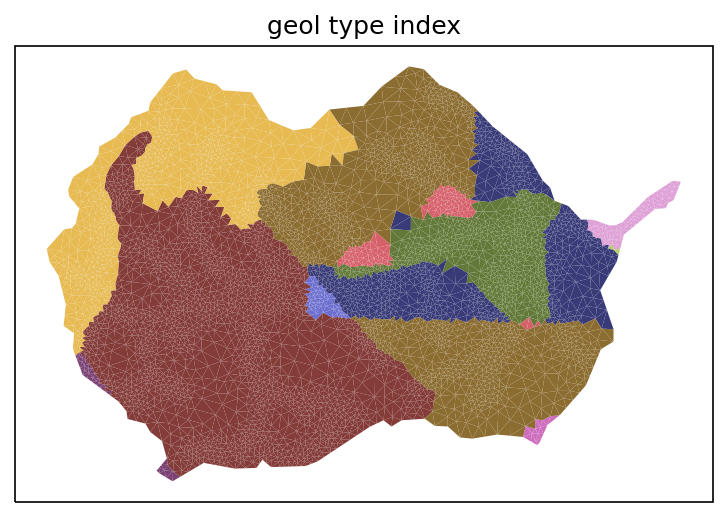

In [129]:
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(geo_color, cmap = 'tab20b')

# plot the geologic formation id
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                                 linewidth=0, color=geo_color, 
                        cmap=cmap, norm = norm
                        )
ax.set_title('geol type index')

# print(geo_survey_props)

# fig.savefig('watershed_geology')

## get bedrock depth

Download global depth to bedrock at 250 m resolution from [soilgrids](http://globalchange.bnu.edu.cn/research/dtb.jsp).

In [130]:
DTB_profile, DTB_raster = workflow.get_raster_on_shape(fname_DTB, watershed.exterior(), crs, nodata=-99999)

2021-03-03 11:24:56,856 - root - INFO: 
2021-03-03 11:24:56,856 - root - INFO: Preprocessing Raster
2021-03-03 11:24:56,857 - root - INFO: ------------------------------
2021-03-03 11:24:56,857 - root - INFO: loading file: "/Users/shua784/OneDrive - PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/global/depth-to-bedrock/Global_absoluteDTB_M_250m_ll.tif"
2021-03-03 11:24:56,859 - root - INFO: collecting raster
2021-03-03 11:24:56,983 - root - INFO: Got raster of shape: (33, 63)
2021-03-03 11:24:56,984 - root - INFO: Raster bounds: (-107.108344996, 38.895007756, -106.977095017, 38.826257767)


In [131]:
# resample the raster to the triangles
DTB_raster = DTB_raster/100 #convert from cm to m
DTB_mesh = workflow.values_from_raster(m2.centroids(), crs, DTB_raster, DTB_profile)

In [132]:
logging.info(f'minimum depth-to-bedrock: {np.nanmin(DTB_mesh)} m')
logging.info(f'maximum depth-to-bedrock: {np.nanmax(DTB_mesh)} m')

2021-03-03 11:24:58,351 - root - INFO: minimum depth-to-bedrock: 3.16 m
2021-03-03 11:24:58,352 - root - INFO: maximum depth-to-bedrock: 26.39 m


### plot depth to bedrock

In [133]:
DTB_3d = workflow.elevate(mesh_points2, crs, DTB_raster, DTB_profile)

2021-03-03 11:24:59,629 - root - INFO: 
2021-03-03 11:24:59,630 - root - INFO: Elevating Triangulation to DEM
2021-03-03 11:24:59,630 - root - INFO: ------------------------------


(316690.15495, 329034.55405000004)
(4299344.330884162, 4307420.049100754)


Text(0.5, 1.0, 'DTB [m]')

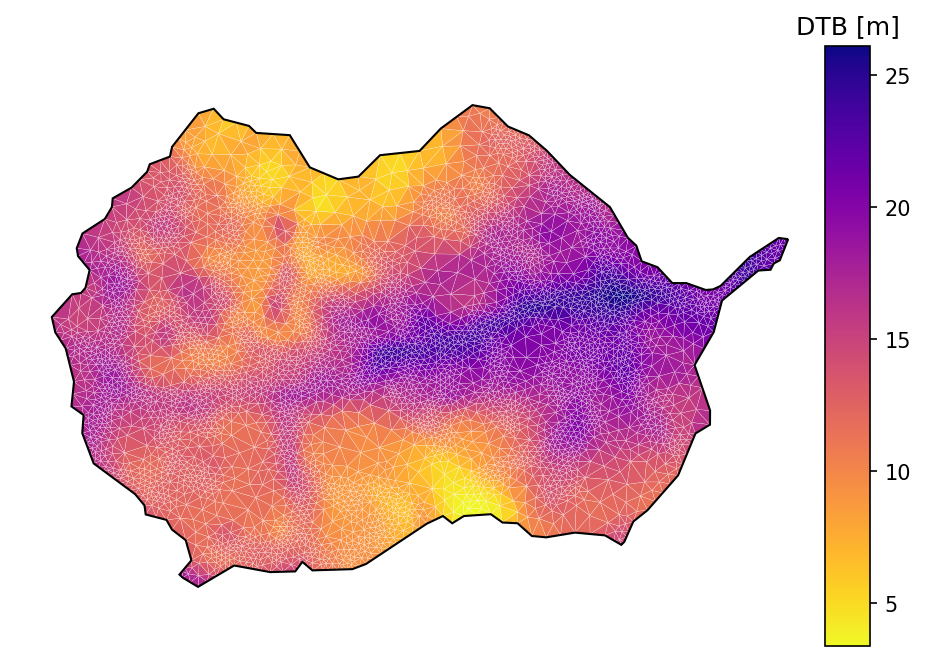

In [134]:
# plot the resulting surface mesh
fig = plt.figure(figsize=(6,5))
ax = workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
cbax = fig.add_axes([.95,0.1,0.05,0.8])

mp = workflow.plot.triangulation(DTB_3d, mesh_tris, crs, ax=ax, 
                                 color='elevation', cmap = 'plasma_r', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)

ax.set_aspect('equal', 'datalim')
ax.axis('off')
# add scalebar, use 1 for UTM coordinates, the default unit is "m"
# scalebar1 = ScaleBar(1, location = "lower left")
# ax.add_artist(scalebar1)

print(ax.get_xlim())
print(ax.get_ylim())
cbar.ax.set_title('DTB [m]')

## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

In [135]:
total_tckness = np.ceil(DTB_mesh.max())
logging.info(f'total thickness: {total_tckness} m')

2021-03-03 11:25:35,592 - root - INFO: total thickness: 27.0 m


In [136]:
ele_per_layer = mesh_tris.shape[0]

In [137]:
def doArraysIntersect(array1, array2):
    return bool(set(array1) & set(array2))

if doArraysIntersect(geo_id_df.index, soil_id_df.index) or doArraysIntersect(geo_id_df.index, [999]) or doArraysIntersect(soil_id_df.index, [999]):
    raise RuntimeWarning('Common id is found in either soil/geol/bedrock!')

In [138]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []
z_top = []

z = 0.0
z_top.append(z)
# -- soil layer --
#  top 2 m
#  5 cm initial top cell
#  expanding dz, growing with depth
ncells = 6
dz = 0.05
layer_dz = 2 # total top thickness

# tele = workflow.mesh.telescope_factor(ncells, dz, layer_dz)
tele = 1.75 
logging.info("Got telescoping factor: {}".format(tele))
for i in range(ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(soil_color)
    z += dz
    dz = round(dz * tele, 2)
    z_top.append(z)    

# -- geologic layer --
# keep going for 2m cells until we hit the bottom of
# the domain
dz = 2.0

geo_ncells = int(np.ceil((total_tckness-z)/dz))
for i in range(geo_ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(geo_color)
    z += dz    
    z_top.append(z)

# print the summary
workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2021-03-03 11:25:35,695 - root - INFO: Got telescoping factor: 1.75
2021-03-03 11:25:35,697 - root - INFO: Cell summary:
2021-03-03 11:25:35,698 - root - INFO: ------------------------------------------------------------
2021-03-03 11:25:35,698 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2021-03-03 11:25:35,699 - root - INFO: ------------------------------------------------------------
2021-03-03 11:25:35,699 - root - INFO:  00 	| 00 	| 509532 	|   0.050000 	|   0.000000
2021-03-03 11:25:35,700 - root - INFO:  01 	| 01 	| 509532 	|   0.090000 	|   0.050000
2021-03-03 11:25:35,700 - root - INFO:  02 	| 02 	| 509532 	|   0.160000 	|   0.140000
2021-03-03 11:25:35,700 - root - INFO:  03 	| 03 	| 509532 	|   0.280000 	|   0.300000
2021-03-03 11:25:35,701 - root - INFO:  04 	| 04 	| 509532 	|   0.490000 	|   0.580000
2021-03-03 11:25:35,701 - root - INFO:  05 	| 05 	| 509532 	|   0.860000 	|   1.070000
2021-03-03 11:25:35,701 - root - INFO:  06 	| 06 	| 726639 	|   2.000000 	|   1.9300

In [139]:
logging.info(f"No of cells: {len(layer_data)*ele_per_layer}")

2021-03-03 11:25:35,765 - root - INFO: No of cells: 171760


### add bedrock material

In [140]:
# get depth below top cell face
z_top = np.asarray(z_top)
z_center = z_top[:-1] + (z_top[1:]-z_top[:-1])/2

In [141]:
mat_ids = np.stack(layer_mat_ids)

for icol in np.arange(mat_ids.shape[1])[:]:
    idtb = DTB_mesh[icol]
    idx = z_center > idtb
    
    # assign 999 to bedrock
    mat_ids[idx, icol] = 999

In [142]:
layer_mat_ids = [mat_ids[row, :] for row in np.arange(mat_ids.shape[0])]

### extrusion

In [143]:
# extrude
m3 = workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

In [144]:
# add back on land cover side sets
surf_ss = m3.side_sets[1]

for index, name in zip(nlcd_indices, nlcd_labels):
    where = np.where(lc == index)[0]
    ss = workflow.mesh.SideSet(name, int(index), 
                            [surf_ss.elem_list[w] for w in where],
                            [surf_ss.side_list[w] for w in where])        
    m3.side_sets.append(ss)

In [145]:
# save to disk
try:
    os.remove(fname_final_mesh)
except FileNotFoundError:
    pass
m3.write_exodus(fname_final_mesh)

Opening exodus file: ./meshes/CoalCreek_mesh-100m-frac1pct.exo
Closing exodus file: ./meshes/CoalCreek_mesh-100m-frac1pct.exo



## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

First, all integer IDs in Exodus files must be unique.  This includes Material IDs, side sets, etc.  We create the Material ID map and data frame.  This is used to standardize IDs from multiple data sources.  Traditionally, ATS numbers Material IDs/Side Sets as:

* 0-9 : reserved for boundaries, surface/bottom, etc
* 10-99 : Land Cover side sets, typically NLCD IDs are used
* 100-999 : geologic layer material IDs
* 1000-9999 : soil layer material IDs




In [146]:
# soil_survey_props['ats_id'] = range(1000, 1000+len(soil_survey_props))
# soil_survey_props.set_index('ats_id', inplace=True)

# geo_survey_props['ats_id'] = range(100, 100+len(geo_survey_props))
# geo_survey_props.set_index('ats_id', inplace=True)

# subsurface_props = pandas.concat([geo_survey_props,soil_survey_props])

# # must choose properties for geologic media.  Here we choose one that has a similar porosity
# subsurface_props.loc[100, ['residual saturation [-]', 'van Genuchten alpha [Pa^-1]', 'van Genuchten n [-]']] =  \
#       subsurface_props.loc[1024, ['residual saturation [-]', 'van Genuchten alpha [Pa^-1]', 'van Genuchten n [-]']] 

# # save the properties to disk for use in generating input file
# subsurface_props.to_csv('watershed_subsurface_properties.csv')



Next we extrude the DEM to create a 3D mesh.

The most difficult aspect of extrusion is creating meshes that:
1. aren't huge numbers of cells
2. aren't huge cell thicknesses, especially near the surface
3. follow implied interfaces, e.g. bottom of soil and bottom of geologic layer

This is an iterative process that requires some care and some art.

In [147]:
# # Generate a dz structure for the top 2m of soil -- it appears from above that the soil thickness is uniformly 2m
# #
# # here we try for 10 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2m thick soil
# dzs, res = workflow.mesh.optimize_dzs(0.05, 0.5, 2, 10)
# print(dzs)

In [148]:
# # this looks like it would work out:
# dzs = [0.05, 0.05, 0.05, 0.12, 0.23, 0.5, 0.5, 0.5]
# print(sum(dzs))

In [149]:
# a 2m soil thickness and a 17m depth to bedrock suggests a geologic layer of 15 - 1m cells

In [150]:
# # layer extrusion
# # -- data structures needed for extrusion
# layer_types = []
# layer_data = []
# layer_ncells = []
# layer_mat_ids = []

# # -- soil layer --
# for dz in dzs:
#     layer_types.append('constant')
#     layer_data.append(dz)
#     layer_ncells.append(1)
#     layer_mat_ids.append(soil_color)
    
# # -- geologic layer --
# layer_types.append('constant')
# layer_data.append(15)
# layer_ncells.append(15)
# layer_mat_ids.append(geo_color)

# # print the summary
# workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
#                                             layer_ncells, layer_mat_ids)

In [151]:
# # extrude
# m3 = workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
#                                              layer_ncells, layer_mat_ids)

# # add back on land cover side sets
# surf_ss = m3.side_sets[1]

# for index, name in zip(nlcd_indices, nlcd_labels):
#     where = np.where(lc == index)[0]
#     ss = workflow.mesh.SideSet(name, int(index), 
#                             [surf_ss.elem_list[w] for w in where],
#                             [surf_ss.side_list[w] for w in where])        
#     m3.side_sets.append(ss)

# # save to disk
# try:
#     os.remove('watershed_basin.exo')
# except FileNotFoundError:
#     pass
# m3.write_exodus('watershed_basin.exo')